# Quantum Hamming Decoding on Amazon Braket
This file demonstrates the algorithm explained in our paper **"Quantum Channel Decoding"** as submitted to the [QEC-22 conference](https://qce.quantum.ieee.org/2022/).

Please refer to the readme file in this folder for more information about setting up the environment, installing the required packages, and getting ready to run this notebook with Amazon Braket.

Copyright &copy; 2022 InterDigital AI Research Lab

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from quantumhammingdecoder import QuantumHamming
QuantumHamming.setPlatform("BRAKET")   # By default this is set to QISKIT if both packages are installed

Software platform changed to 'BRAKET'.


ou can unremark the other devices to run on Braket's simulators or real quantum computers. Before selecting a device, in Amazon Braket, go to ``Devices`` and make sure it is currently available. Also please note that even if the device is available, it will probably run slower than your local device simulation. So, please be patient.

In [2]:
from braket.aws import AwsDevice
from braket.devices import LocalSimulator

device = LocalSimulator()
# device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
# device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1")
# device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
# device = AwsDevice("arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy")

## Creating a QuantumHamming class
Here we first create a ``QuantumHamming`` class for (7,4) Hamming Decoding, which means we are using 4-bit messages embedded in 7-bit code-words. The ``getRandomMessage`` method creates a random message and returns it together with the corresponding code-word, BPSK-modulated signal, and noisy received signal. 

Then we print the message information before calling a series of decoding functions to decode the noisy received signal using **Hard Decision**, **Maximum Likelihood**, and **Quantum** algorithms.

In [3]:
qh = QuantumHamming(7, device=device)

ebNoDb = 4
# Create a random message (msg), and the corresponding codeWord, BPSK transmitted signal (tx), noisy
# received signal (rx), and the noise power based on the given Eb/N0 value (sigma2).
msg, codeWord, tx, rx, sigma2 = qh.getRandomMessage(ebNoDb)
print("Message:       ", "  ".join("%4d"%(x) for x in msg))
print("codeWord:      ", "  ".join("%4d"%(x) for x in codeWord))
print("Noisy Rx:       ", "  ".join("%4.1f"%(x) for x in rx))
cwHat = np.int8(rx<0)
print("Hard-Decision: ","  ".join("%4d"%(x) for x in cwHat))
print("Num bit errors:", sum((cwh!=cw) for cwh, cw in zip(cwHat,codeWord)), "(Hard Decision)")

print("\nDecoding with different algorithms:")
print("  Org. Message:                          ", "  ".join("%1d"%(x) for x in msg))

# Decode the received signal rx to get the original message:
# Using Hard Decision. The parity bits are used to do error correction.
msgHat = qh.hardDecode(rx, minDist=False)
print("  Decoded Message(Hard-Error Correction):", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")

# Using Hard Decision and selecting based on minimum hamming distance
msgHat = qh.hardDecode(rx)
print("  Decoded Message(Hard-MinDist):         ", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")

# Using Soft Decision and Maximum Likelihood based on maximum correlation between rx and all possible codewords
msgHat = qh.softDecode(rx)
print("  Decoded Message(Maximum Likelihood):   ", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")

# Using Quantum Fast decoding (based on the highest count)
msgHat = qh.decodeFast(rx)
print("  Decoded Message(Quantum-Fast):         ", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")

# Using Quantum plus ML:
msgHat = qh.decode(rx)
print("  Decoded Message(Quantum):              ", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")

# Using Quantum plus ML plus Error Correction:
msgHat = qh.decode(rx, correctErrors=True)
print("  Decoded Message(Quantum+Correction):   ", "  ".join("%1d"%(x) for x in msgHat), "✓" if np.all(msgHat==msg) else "X")


Message:           1     1     1     0
codeWord:          0     0     1     0     1     1     0
Noisy Rx:         0.8  -0.2  -0.9   1.1  -1.7   0.1   1.2
Hard-Decision:     0     1     1     0     1     0     0
Num bit errors: 2 (Hard Decision)

Decoding with different algorithms:
  Org. Message:                           1  1  1  0
  Decoded Message(Hard-Error Correction): 1  1  0  0 X
  Decoded Message(Hard-MinDist):          1  1  0  0 X
  Decoded Message(Maximum Likelihood):    1  1  1  0 ✓
  Decoded Message(Quantum-Fast):          1  1  0  0 X
  Decoded Message(Quantum):               1  1  1  0 ✓
  Decoded Message(Quantum+Correction):    1  1  1  0 ✓


## The quantum results statistics after executing the circuit
Now we print the bitstreams with highest "counts" and draw a histogram based on the counts. Here is an explanation of the columns:
- Qubits: The measured Qubits at the output of the quantum circuit
- Count: The number of times the bit-stream in ``Qubits`` was measured at the output of quantum circuit
- MSG: The message extracted from the qubits using message bit indexes
- Code-Word: The code-word obtained by applying the generator matrix G to the ``MSG``
- Correlation: The correlation between ``Code-Word`` and the noisy received signal
- Check: The ``n-k`` parity check bits. Zero means no error, otherwise shows the location of error.
- CW (rx): The code-word based on the received signal. May not be a valid code-word due to noise.
- CW (cor): The corrected code-word obtained from applying ``Check`` to ``CW (rx)``.
- MSG (cor): The corrected message extracted ``CW (cor)``
- Corrl (cor): The correlation between ``CW (cor)`` and the noisy received signal


All Candidates:
    Qubits   Count  MSG   Code-Word  Correlation  Check  CW (rx)  CW (cor)  MSG (cor)  Corrl (cor)
    PPMPMMM               CCMCMMM                        CCMCMMM  CCMCMMM                         
    0011100  422    1100  0111100    3.8300       001    0110100  0111100   1100       3.8300       --
    0110110  251    1110  0010110    5.3452       010    0110110  0010110   1110       5.3452       ✓✓
    0111100  185    1100  0111100    3.8300       011    0010100  1001100   0100       -0.0939      --
    0010110  96     1110  0010110    5.3452       000    0010110  0010110   1110       5.3452       ✓✓
    1011100  13     1100  0111100    3.8300       101    1110100  1110000   1000       0.9946       --
    1101100  8      0100  1001100    -0.0939      111    0100100  0100101   0101       1.9410       --
    1110110  7      1110  0010110    5.3452       110    1110110  0111100   1100       3.8300       ✓-
    1010110  6      1110  0010110    5.3452       100    1010110

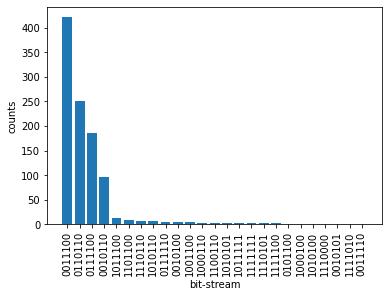

In [4]:
qh.printStats(rx,msgHat, msg)


## Showing the Quantum Hamming Decoder circuit
Now we can print the circuit and its depth.

In [5]:
print("Circuit Depth:", qh.circuit.depth)
print(qh.circuit)

Circuit Depth: 6
T  : |   0    |1| 2 |  3  | 4 |5|
                                 
q0 : -Ry(0.36)-X-X---X-----------
               | |   |           
q1 : -Ry(1.99)-|-|-X-|-X---X-----
               | | | | |   |     
q2 : -Ry(2.81)-C-|-C-|-|---|-----
                 |   | |   |     
q3 : -Ry(0.22)---|---|-|-X-|-X-X-
                 |   | | | | | | 
q4 : -Ry(3.07)---C---|-|-C-|-|-|-
                     | |   | | | 
q5 : -Ry(1.30)-------|-C---|-C-|-
                     |     |   | 
q6 : -Ry(0.20)-------C-----C---C-

T  : |   0    |1| 2 |  3  | 4 |5|
